In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

In [41]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Dataset

In [42]:
dataset = pd.read_csv('../../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
# data.tail(10)

### Dataset Information

In [5]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [7]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
stages_supervised = series_to_supervised(stages, n_hours, K)
stages_supervised.reset_index(drop=True, inplace=True)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [8]:
# stages_supervised

#### Prior unknown covariates (6)

In [9]:
prior_unknown_cov = data[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown_cov.shape:", prior_unknown_cov.shape)

prior_unknown_cov_supervised = series_to_supervised(prior_unknown_cov, n_hours, K)
print("prior_unknown_cov_supervised.shape:", prior_unknown_cov_supervised.shape)

prior_unknown_cov.shape: (96432, 6)
prior_unknown_cov_supervised.shape: (96337, 576)


In [10]:
prior_unknown_cov_supervised.reset_index(drop=True, inplace=True)
prior_unknown_cov_supervised.columns = ['past_unknown_cov_' + i for i in list(prior_unknown_cov_supervised.columns)]

In [11]:
prior_unknown_cov_supervised

,past_unknown_cov_var1(t-72),past_unknown_cov_var2(t-72),past_unknown_cov_var3(t-72),past_unknown_cov_var4(t-72),past_unknown_cov_var5(t-72),past_unknown_cov_var6(t-72),past_unknown_cov_var1(t-71),past_unknown_cov_var2(t-71),past_unknown_cov_var3(t-71),past_unknown_cov_var4(t-71),...,past_unknown_cov_var3(t+22),past_unknown_cov_var4(t+22),past_unknown_cov_var5(t+22),past_unknown_cov_var6(t+22),past_unknown_cov_var1(t+23),past_unknown_cov_var2(t+23),past_unknown_cov_var3(t+23),past_unknown_cov_var4(t+23),past_unknown_cov_var5(t+23),past_unknown_cov_var6(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
2,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
3,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
4,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
96333,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.0,1.94,504.67,2.39,...,0.0,2.89,287.12,2.54,0.0,1.94,0.0,2.90,253.27,2.58


#### Prior known covariates (9)

In [12]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (96432, 9)
prior_known_cov_supervised.shape: (96337, 864)


In [13]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [14]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var1(t-71),...,past_known_cov_var9(t+22),past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23)
0,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.42,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.008750,-0.01,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


In [15]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var1(t+1),...,past_known_cov_var9(t+22),past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23)
0,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.47,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.83,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.31,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.18,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.18,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.55,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,2.08,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.92,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.92,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.55,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,1.55,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.08,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


In [16]:
prior_known_future_cov.shape

(96337, 216)

### N_out, N_in, K

In [17]:
# specify the number of lag hours
n_features = stages.shape[1] + prior_unknown_cov.shape[1] + prior_known_cov.shape[1]

In [18]:
n_features

19

### Concatenation

In [19]:
past_prior_unknown_cov_supervised = prior_unknown_cov_supervised.iloc[:, :n_hours*prior_unknown_cov.shape[1]]
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [20]:
# prior_known_cov_supervised

In [21]:
columns = []
for i in range(n_hours):
    columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [22]:
past_unknown_known_cov = concat([past_prior_unknown_cov_supervised, past_prior_known_cov_supervised],
                                axis=1)

In [23]:
past_unknown_known_cov

,past_unknown_cov_var1(t-72),past_unknown_cov_var2(t-72),past_unknown_cov_var3(t-72),past_unknown_cov_var4(t-72),past_unknown_cov_var5(t-72),past_unknown_cov_var6(t-72),past_unknown_cov_var1(t-71),past_unknown_cov_var2(t-71),past_unknown_cov_var3(t-71),past_unknown_cov_var4(t-71),...,past_known_cov_var9(t-2),past_known_cov_var1(t-1),past_known_cov_var2(t-1),past_known_cov_var3(t-1),past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.0,1.94,504.67,2.39,...,0.0,1.92,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


In [24]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, stages_supervised.iloc[:, :]], axis=1)

In [25]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 1464)


In [26]:
all_data

,past_unknown_cov_var1(t-72),past_unknown_cov_var2(t-72),past_unknown_cov_var3(t-72),past_unknown_cov_var4(t-72),past_unknown_cov_var5(t-72),past_unknown_cov_var6(t-72),past_unknown_cov_var1(t-71),past_unknown_cov_var2(t-71),past_unknown_cov_var3(t-71),past_unknown_cov_var4(t-71),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.0,1.94,504.67,2.39,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [27]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [28]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 77145


In [29]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [30]:
test_future_cov.shape

(19192, 216)

### Normalization

In [31]:
n_hours

72

In [32]:
n_features

19

In [33]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77145, 1368) (77145, 96) (19192, 1368) (19192, 96)


In [34]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (77145, 216) (19192, 216)


In [35]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77145, 72, 19) (77145, 96) (19192, 72, 19) (19192, 96)


In [36]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (77145, 24, 9) (19192, 24, 9)


In [37]:
train_y = train_y.reshape((train_y.shape[0], K, -1))
test_y = test_y.reshape((test_y.shape[0], K, -1))
print(train_y.shape, test_y.shape)

(77145, 24, 4) (19192, 24, 4)


### Model

In [39]:
# latent_dim = 128

# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')

# encoder = tf.keras.layers.SimpleRNN(96, activation='relu', return_state=True, return_sequences=False)
encoder = tf.keras.layers.SimpleRNN(96, activation='relu', return_state=True, return_sequences=True)
encoder_outputs, state_h = encoder(past_inputs)  # state_h, state_c for LSTM


# Adding the future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')
decoder_lstm = tf.keras.layers.SimpleRNN(96, activation='relu', return_sequences=True)


# Past + Future
x = decoder_lstm(future_inputs, initial_state=[state_h])   # state_h, state_c


# Output
x = tf.keras.layers.Dense(256, activation='relu')(x)

output = tf.keras.layers.Dense(stages.shape[1])(x)

# Combining future inputs with recurrent branch output
model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 19)]     0                                            
__________________________________________________________________________________________________
future_inputs (InputLayer)      [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        [(None, 72, 96), (No 11136       past_inputs[0][0]                
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        (None, 24, 96)       10176       future_inputs[0][0]              
                                                                 simple_rnn_2[0][1]         

Epoch 1/1000

Epoch 00001: val_mae improved from inf to 0.40089, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 0.1272 - mae: 0.3277 - val_loss: 0.1947 - val_mae: 0.4009
Epoch 2/1000

Epoch 00002: val_mae improved from 0.40089 to 0.23737, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 0.0733 - mae: 0.2329 - val_loss: 0.0836 - val_mae: 0.2374
Epoch 3/1000

Epoch 00003: val_mae improved from 0.23737 to 0.14599, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 0.0251 - mae: 0.1276 - val_loss: 0.0319 - val_mae: 0.1460
Epoch 4/1000

Epoch 00004: val_mae improved from 0.14599 to 0.13074, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 0.0153 - mae: 0.1025 - val_loss: 0.0249 - val_mae: 0.1307
Epoch 5/1000

Epoch 00005: val_mae improved from 0.13074 to 0.12018, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 0.0125 - mae

Epoch 40/1000

Epoch 00040: val_mae improved from 0.03193 to 0.03137, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 4.8310e-04 - mae: 0.0150 - val_loss: 0.0015 - val_mae: 0.0314
Epoch 41/1000

Epoch 00041: val_mae improved from 0.03137 to 0.03092, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 4.7066e-04 - mae: 0.0148 - val_loss: 0.0014 - val_mae: 0.0309
Epoch 42/1000

Epoch 00042: val_mae improved from 0.03092 to 0.03084, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 4.5942e-04 - mae: 0.0145 - val_loss: 0.0014 - val_mae: 0.0308
Epoch 43/1000

Epoch 00043: val_mae improved from 0.03084 to 0.03031, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 4.4861e-04 - mae: 0.0143 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 44/1000

Epoch 00044: val_mae improved from 0.03031 to 0.02993, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 

Epoch 85/1000

Epoch 00085: val_mae did not improve from 0.02613
151/151 - 7s - loss: 2.7271e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 86/1000

Epoch 00086: val_mae did not improve from 0.02613
151/151 - 7s - loss: 2.7139e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 87/1000

Epoch 00087: val_mae improved from 0.02613 to 0.02558, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 2.7005e-04 - mae: 0.0100 - val_loss: 0.0010 - val_mae: 0.0256
Epoch 88/1000

Epoch 00088: val_mae did not improve from 0.02558
151/151 - 7s - loss: 2.6888e-04 - mae: 0.0099 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 89/1000

Epoch 00089: val_mae did not improve from 0.02558
151/151 - 7s - loss: 2.6761e-04 - mae: 0.0099 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 90/1000

Epoch 00090: val_mae did not improve from 0.02558
151/151 - 7s - loss: 2.6642e-04 - mae: 0.0099 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 91/1000

Epoch 00091: val_mae did not i

Epoch 139/1000

Epoch 00139: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2832e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 140/1000

Epoch 00140: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2784e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 141/1000

Epoch 00141: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2751e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 142/1000

Epoch 00142: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2653e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 143/1000

Epoch 00143: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2600e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 144/1000

Epoch 00144: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2567e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 145/1000

Epoch 00145: val_mae did not improve from 0.02548
151/151 - 7s - loss: 2.2505e-04 - mae: 0

Epoch 193/1000

Epoch 00193: val_mae did not improve from 0.02512
151/151 - 7s - loss: 2.0042e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 194/1000

Epoch 00194: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9999e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 195/1000

Epoch 00195: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9944e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 196/1000

Epoch 00196: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9901e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 197/1000

Epoch 00197: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9851e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 198/1000

Epoch 00198: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9817e-04 - mae: 0.0085 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 199/1000

Epoch 00199: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.9769e-04 - mae: 0

Epoch 248/1000

Epoch 00248: val_mae did not improve from 0.02512
151/151 - 7s - loss: 1.7682e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 249/1000

Epoch 00249: val_mae improved from 0.02512 to 0.02509, saving model to saved_model/rnn_encoder_decoder_12h_ws_cp3.h5
151/151 - 7s - loss: 1.7651e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 250/1000

Epoch 00250: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.7607e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 251/1000

Epoch 00251: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.7555e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 252/1000

Epoch 00252: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.7527e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 253/1000

Epoch 00253: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.7484e-04 - mae: 0.0082 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 254/1000

Epoch 00254: val_mae di

Epoch 303/1000

Epoch 00303: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.6128e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 304/1000

Epoch 00304: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.6077e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 305/1000

Epoch 00305: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.6065e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 306/1000

Epoch 00306: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.6040e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 307/1000

Epoch 00307: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.6034e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 308/1000

Epoch 00308: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.5985e-04 - mae: 0.0079 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 309/1000

Epoch 00309: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.5980e-04 - mae: 0

Epoch 358/1000

Epoch 00358: val_mae did not improve from 0.02509
151/151 - 6s - loss: 1.5087e-04 - mae: 0.0077 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 359/1000

Epoch 00359: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.5060e-04 - mae: 0.0077 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 360/1000

Epoch 00360: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.5031e-04 - mae: 0.0077 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 361/1000

Epoch 00361: val_mae did not improve from 0.02509
151/151 - 6s - loss: 1.5019e-04 - mae: 0.0077 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 362/1000

Epoch 00362: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4987e-04 - mae: 0.0077 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 363/1000

Epoch 00363: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4976e-04 - mae: 0.0077 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 364/1000

Epoch 00364: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4967e-04 - mae: 0

Epoch 413/1000

Epoch 00413: val_mae did not improve from 0.02509
151/151 - 6s - loss: 1.4201e-04 - mae: 0.0075 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 414/1000

Epoch 00414: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4192e-04 - mae: 0.0075 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 415/1000

Epoch 00415: val_mae did not improve from 0.02509
151/151 - 6s - loss: 1.4191e-04 - mae: 0.0075 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 416/1000

Epoch 00416: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4157e-04 - mae: 0.0074 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 417/1000

Epoch 00417: val_mae did not improve from 0.02509
151/151 - 6s - loss: 1.4152e-04 - mae: 0.0074 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 418/1000

Epoch 00418: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4138e-04 - mae: 0.0074 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 419/1000

Epoch 00419: val_mae did not improve from 0.02509
151/151 - 7s - loss: 1.4122e-04 - mae: 0

Epoch 00467: early stopping


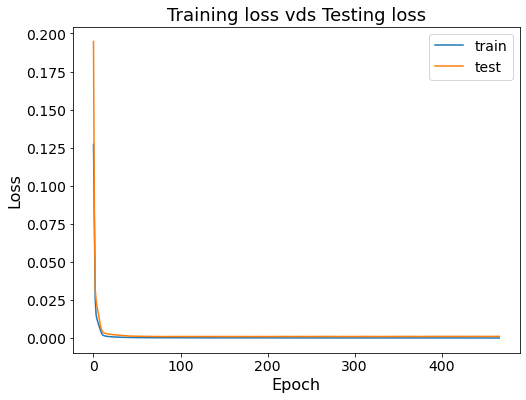

In [127]:
lr = 0.00001
EPOCHS = 1000
model.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=300)
mc = ModelCheckpoint('saved_model/rnn_encoder_decoder_24h_ws.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [128]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/rnn_encoder_decoder_24h_ws.h5')

### Prediction

In [129]:
y_hat = model.predict([test_X, test_future_cov])

In [130]:
print(y_hat.shape)
y_hat = y_hat.reshape((-1, y_hat.shape[1]*y_hat.shape[2]))
print(y_hat.shape)

print(test_y.shape)
test_y = test_y.reshape((-1, test_y.shape[1]*test_y.shape[2]))
print(test_y.shape)

(19204, 12, 4)
(19204, 48)
(19204, 12, 4)
(19204, 48)


In [131]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19204, 48) (19204, 48)


### Performance

In [132]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.133
RMSE = 0.178
